### Imports

In [19]:
import pandas as pd
import matplotlib

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

### Read data

In [2]:
business = pd.read_json('business.json', lines=True)

In [3]:
review = pd.read_json('review.json', lines=True, chunksize=100000)

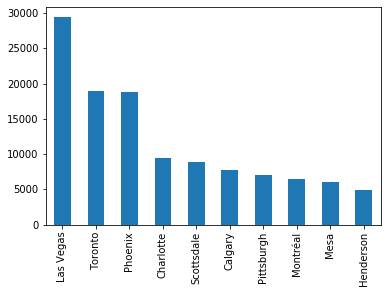

In [4]:
business.city.value_counts()[0:10].plot(kind='bar')

In [5]:
city_business = business[business.city == 'Pittsburgh']
city_business_ids = pd.DataFrame(city_business.business_id)

### Merge Data

In [6]:
temp = []
for i in review:
    temp.append(city_business_ids.merge(i.drop('stars', axis=1), on='business_id', how='left'))
merged = pd.concat(temp)

### Format data matrix
The goal of the model is to predict business stars based on review text
want a matrix with business stars and text for all reviews
use nltk to do modeling and sentiment analysis

In [7]:
merged.drop(['user_id',
             'review_id',
             'useful',
             'funny',
             'cool',
             'date'],
            axis=1,
            inplace=True)
merged = merged[pd.notnull(merged.text)]
merged.reset_index(drop=True, inplace=True)

In [8]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225496 entries, 0 to 225495
Data columns (total 2 columns):
business_id    225496 non-null object
text           225496 non-null object
dtypes: object(2)
memory usage: 3.4+ MB


### Build word buckets

In [9]:
df_buckets = pd.DataFrame(merged.groupby('business_id').text.sum())

In [10]:
df_buckets = df_buckets.merge(pd.concat([city_business.business_id, city_business.stars], axis=1), on='business_id', how='left')
df_buckets = df_buckets.astype({'stars': 'category'})

In [11]:
df_buckets.head()

,business_id,text,stars
0,--cgVkbWTiga3OYTkymKqA,Ted Eazor is one of the most honest people I h...,5.0
1,--cjBEbXMI2obtaRHNSFrA,I had been to Howl at the Moon in Charlotte an...,3.0
2,--ujyvoQlwVoBgMYtADiLA,"Great, attentive service with great local Pitt...",3.5
3,--wIGbLEhlpl_UeAIyDmZQ,"Awesome, fantastic, friendly---I honestly can'...",4.5
4,-0K4W5p3wbQe_vDoB5jMgQ,Students get a 5% discount and they have Asian...,4.0


* df_buckets contains all review text for each business as well as business average rating
* review text is the X matrix
* stars is the y vector

### Clean text

In [28]:
# TODO: stemming

def pipeline(text):
    stops = stopwords.words('english')
    stemmer = PorterStemmer()
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if not word in stops]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens
    

### Create and train model

In [29]:
# TODO:
    # Is there a better vectorizer?
    # Optimize parameters for vectorizer
        # max features

vectorizer = CountVectorizer(min_df=7,
                             max_df=0.8,
                             ngram_range=(1, 2),
                             max_features=2500,
                             tokenizer=pipeline
                            )
X = vectorizer.fit_transform(df_buckets.text)
X

<7017x647 sparse matrix of type '<class 'numpy.int64'>'
	with 1623196 stored elements in Compressed Sparse Row format>

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, df_buckets.stars, test_size=0.2, random_state=0)

In [31]:
knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.40704659719367076

In [32]:
# 12 neighbors gives the highest score

This accuracy score is still really low